In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 150

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from astropy.stats import LombScargle

from maelstrom.maelstrom import Maelstrom

/Users/dforeman/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
# kicid = 6862920
kicid = 11754974

data = np.loadtxt("data/kic{0}_lc.txt".format(kicid))
fulltimes = data[:, 0] # days
tmid = 0.5*(fulltimes[0] + fulltimes[-1])
times = fulltimes - tmid
dmmags = data[:, 1] * 1000. # mmags

# times = times[2500:]
# dmmags = dmmags[2500:]

metadata = np.loadtxt("data/kic{0}_metadata.csv".format(kicid), delimiter=",", skiprows=1)
nu_arr = metadata[::6]

orbits = pd.read_csv("data/orbits.csv").rename(columns = lambda x: x.strip())

orb_params = orbits[orbits.Name == "kic{0}".format(kicid)].iloc[0]
porb = orb_params.Porb
a1 = orb_params["a1sini/c"]
tp = orb_params["t_p"] - tmid
e = orb_params["e"]
varpi = orb_params["varpi"]
a1d = a1/86400.0

In [4]:
tmax = times.max()
tmin = times.min()
dt = np.median(np.diff(times))
df = 1.0 / (tmax - tmin)
ny = 0.5 / dt

freq = np.arange(df, 2 * ny, df)
print(df, freq.shape)
power = LombScargle(times, dmmags).power(freq)

0.000740412792774 (66097,)


In [5]:
# Find and fit peaks
max_peaks = len(nu_arr)
peak_inds = (power[1:-1] > power[:-2]) & (power[1:-1] > power[2:])
peak_inds = np.arange(1, len(power)-1)[peak_inds]
peak_inds = peak_inds[np.argsort(power[peak_inds])][::-1]
peaks = []
for j in range(max_peaks):
    i = peak_inds[0]
    freq0 = freq[i]
    alias = 2.0*ny - freq0
    
    m = np.abs(freq[peak_inds] - alias) > 10*df
    m &= np.abs(freq[peak_inds] - freq0) > 10*df

    peak_inds = peak_inds[m]
    peaks.append((freq0, power[i]))

peaks = np.array(peaks)
peaks

array([[  1.63446124e+01,   7.76059010e-01],
       [  2.13986701e+01,   1.86467658e-02]])

In [6]:
nu_arr

array([ 16.34475466,  21.39900267])

In [8]:
delta = np.abs(nu_arr[:, None] - peaks[:, 0][None, :])
np.min(delta, axis=0), np.min(delta, axis=1)

(array([ 0.00014226,  0.00033254]), array([ 0.00014226,  0.00033254]))

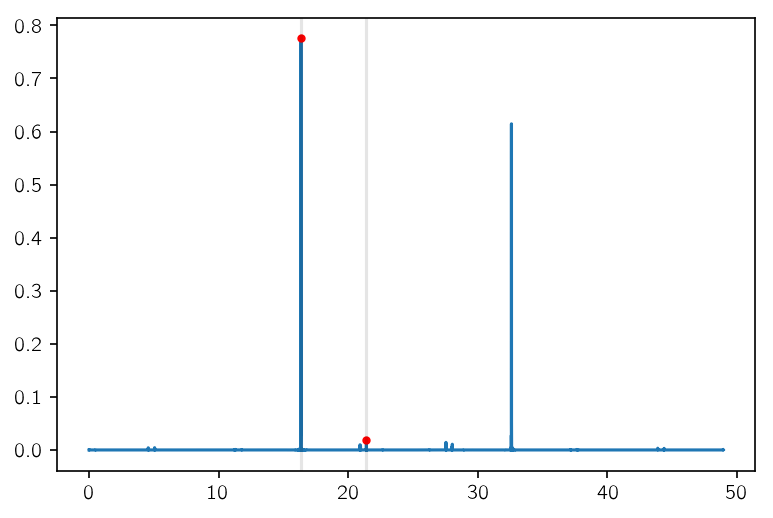

In [9]:
plt.plot(freq, power)
plt.plot(peaks[:, 0], peaks[:, 1], ".r")
for n in nu_arr:
    plt.axvline(n, color="k", alpha=0.1)
# plt.xlim(df, ny)
# plt.yscale("log")

In [66]:
model = Maelstrom(times, dmmags, peaks[:, 0])
model.init_from_orbit(period=porb, lighttime=a1d, tref=tp, eccen=0.1)
                      # eccen=e, varpi=varpi)

In [67]:
model.get_session().run(model.chi2)

13961123.317470197

In [68]:
model.optimize([model.nu])

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 5263390.957536
  Number of iterations: 9
  Number of functions evaluations: 19


In [69]:
model.optimize([model.period, model.tref])

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 4894542.361971
  Number of iterations: 8
  Number of functions evaluations: 11


In [70]:
model.optimize([model.period, model.tref, model.lighttime])

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 4894495.047092
  Number of iterations: 6
  Number of functions evaluations: 9


In [71]:
model.get_lighttime_estimates()

[array([ 0.00152462,  0.0014874 ]),
 array([  4.02889588e+11,   3.11238803e+10])]

In [72]:
model.pin_lighttime_values()

(array([0, 0], dtype=int32), array([ 0.00152195]))

In [73]:
model.get_lighttime_estimates()

[array([ 0.00152195,  0.00152195]),
 array([  4.02889337e+11,   3.11230092e+10])]

In [85]:
model.optimize([model.eccen_param, model.varpi])

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 4889629.697930
  Number of iterations: 2
  Number of functions evaluations: 5


In [86]:
model.optimize([model.period, model.log_sigma2, model.tref, model.lighttime, model.eccen_param, model.varpi])

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 282509.518911
  Number of iterations: 21
  Number of functions evaluations: 32


In [87]:
model.optimize([model.nu])

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 282509.503320
  Number of iterations: 3
  Number of functions evaluations: 8


In [88]:
model.nu_data - model.get_session().run(model.nu)

array([-0.00013245, -0.00031948])

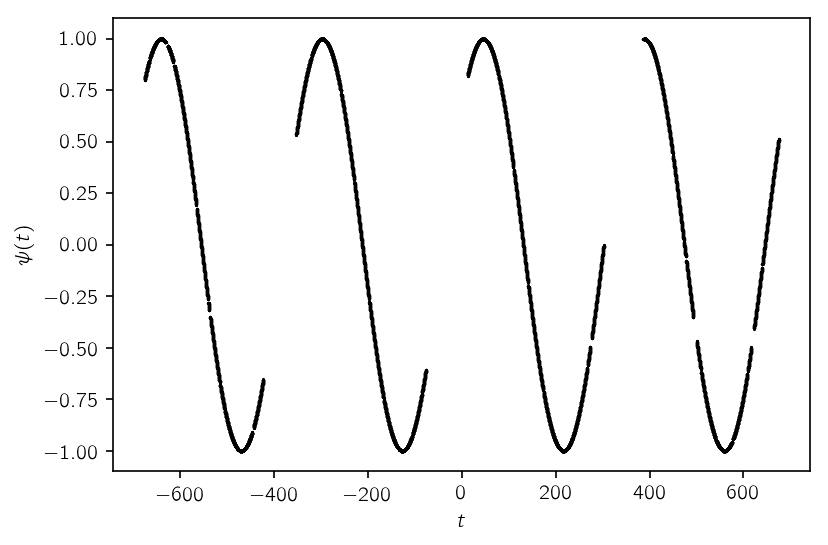

In [93]:
plt.plot(times, model.run(model.psi), ".k", ms=1)
plt.ylabel("$\psi(t)$")
plt.xlabel("$t$");

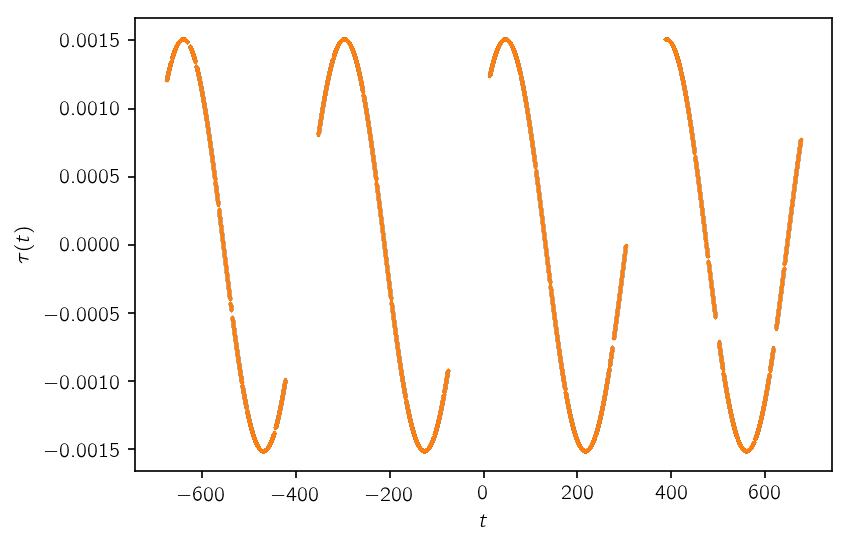

In [94]:
plt.plot(times, model.run(model.tau), ".", ms=1)
plt.ylabel(r"$\tau(t)$")
plt.xlabel("$t$");

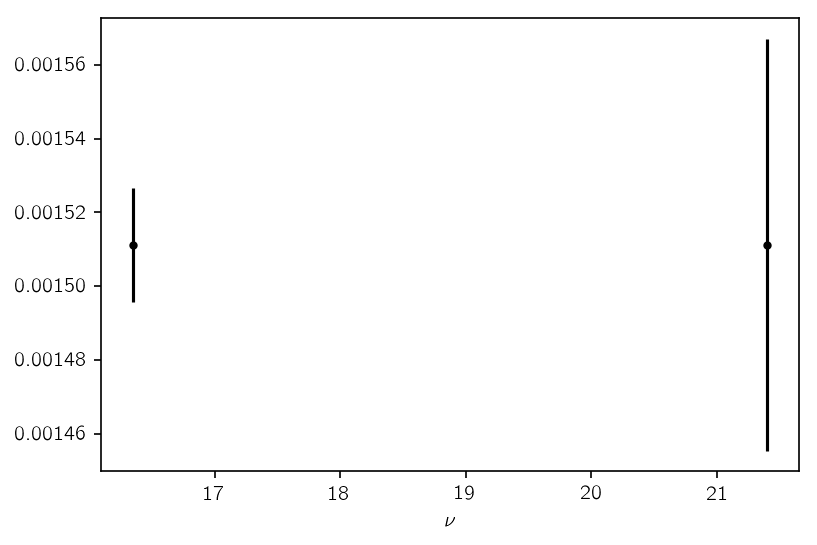

In [95]:
lt, lt_ivar = model.get_lighttime_estimates()
lt_err = np.sqrt(1./lt_ivar)
nu = model.run(model.nu)
plt.errorbar(nu, lt, yerr=lt_err, fmt="k.")
# plt.ylim(-0.01, 0.01)
plt.xlabel(r"$\nu$")

In [96]:
model.run(model.eccen)

0.0084591511553728932

In [81]:
orb_params

Name                   kic11754974
Porb                       343.242
Porb_sig_p                0.500622
Porb_sig_m                0.497353
a1sini/c                   131.138
a1sini/c_sig_p             1.17293
a1sini/c_sig_m             1.18227
e                         0.018982
e_sig_p                   0.017421
e_sig_m                   0.011861
phip                      0.451625
phip_sig_p                0.132112
phip_sig_m                0.276224
varpi                     0.737616
varpi_sig_p               0.844385
varpi_sig_m                1.75724
f(M)Msun                 0.0205526
f(M)Msun_sig_p           0.0005547
f(M)Msun_sig_m           0.0005591
gradient                 -0.009368
grad_sig_p                0.002241
grad_sig_m                0.002392
t_p                        55113.4
t_p_sig_p                  45.3491
t_p_sig_m                  94.8129
K1_ms                       8328.6
K1_ms_sig_p                   48.6
K1_ms_sig_m                     46
median_segment_size 